In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics import tsaplots
from arch import arch_model
import statsmodels.graphics.tsaplots as sgt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [93]:
df_precios = pd.read_csv('Datos/Transformados/dow_jones_clean.csv')
df_precios['Unnamed: 0'] = pd.to_datetime(df_precios['Unnamed: 0'] )
df_precios.set_index('Unnamed: 0', inplace=True)

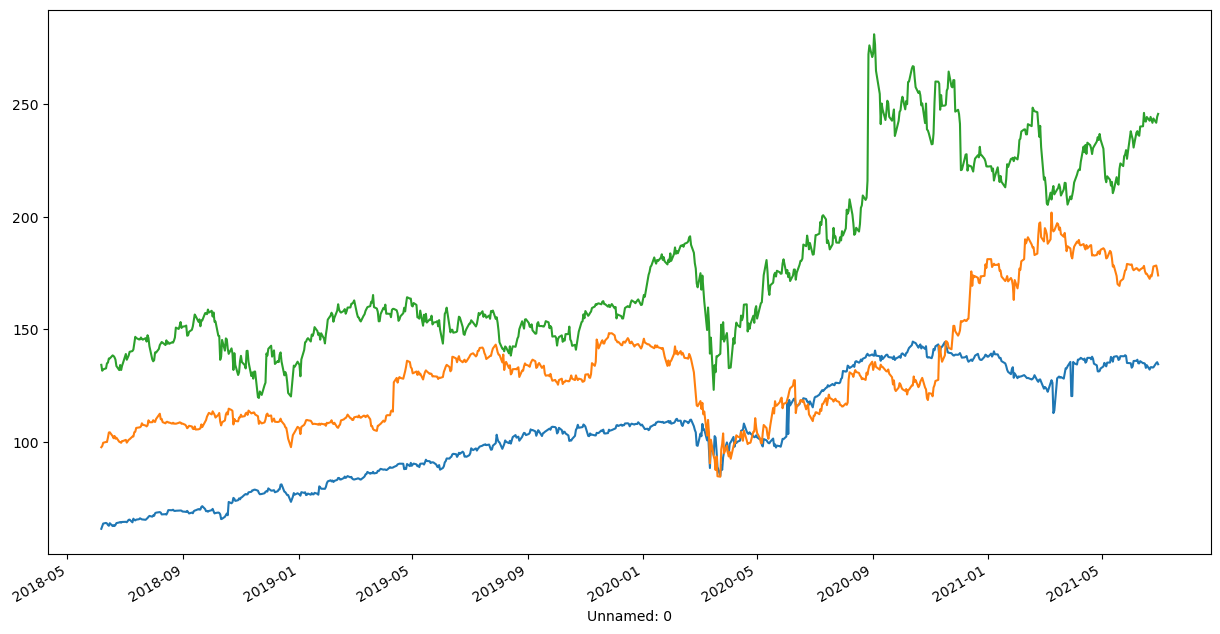

In [94]:
tickers = ['PG', 'DIS', 'CRM']
for ticker in tickers:
    serie = df_precios[ticker]
    serie.plot(figsize = (15,8))

In [95]:
df = df_precios[tickers]

In [96]:

df

,PG,DIS,CRM
Unnamed: 0,,,
2018-06-06,61.173691,97.482872,134.138992
2018-06-07,62.333824,98.018547,131.526474
2018-06-08,63.502163,99.462952,132.139984
2018-06-11,63.790134,99.816864,132.585312
2018-06-12,63.551540,99.797737,134.841583
...,...,...,...
2021-06-24,132.930000,175.330000,241.840000
2021-06-25,133.020000,177.930000,243.770000
2021-06-28,134.920000,178.350000,241.870000


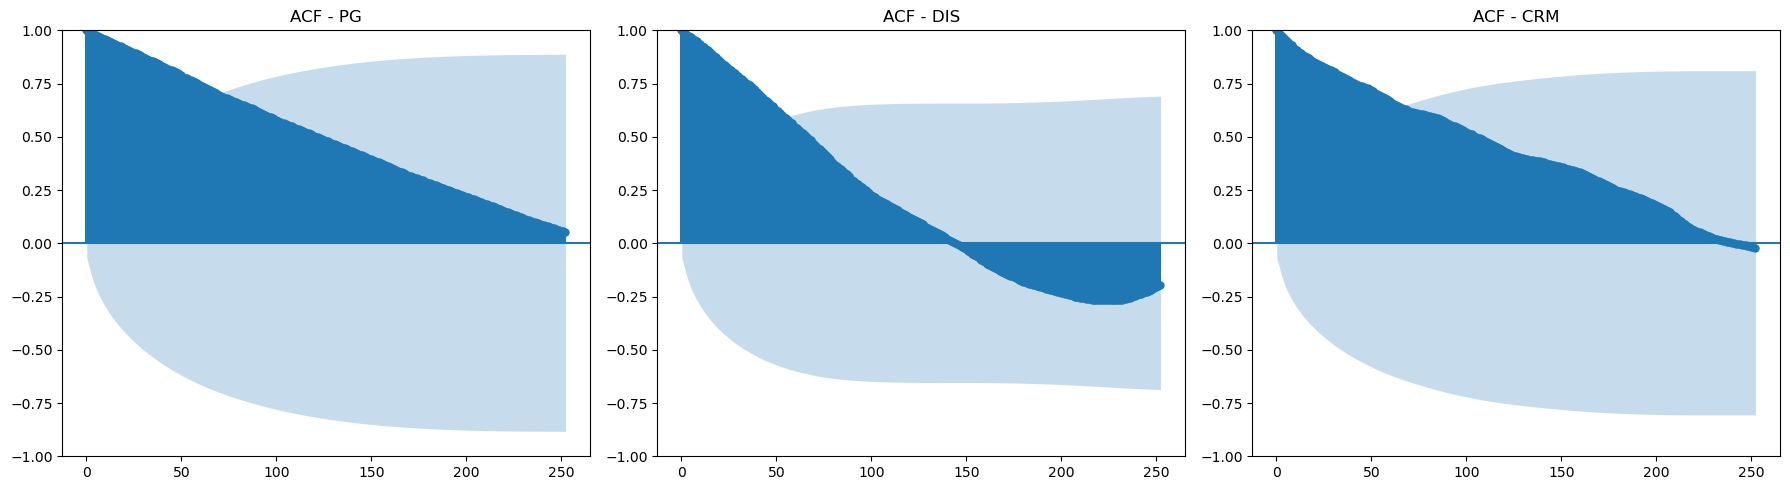

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 fila, 3 columnas

for i, ticker in enumerate(tickers):
    tsaplots.plot_acf(df_precios[ticker].dropna(), lags=252, ax=axes[i])
    axes[i].set_title(f"ACF - {ticker}")

plt.tight_layout()
plt.show()


In [98]:
# Descomposición para cada activo
for ticker in tickers:
    
    # Tomamos la serie temporal de precios ajustados
    serie = df_precios[ticker].dropna()
    
    # Descomposición clásica aditiva (suponiendo datos diarios, periodo=252 días ~ 1 año)
    decomposition = seasonal_decompose(serie, model='additive', period=252)
    
    # Componentes
    tendencia = decomposition.trend
    estacional = decomposition.seasonal
    residuo = decomposition.resid
    
    lm_test = het_arch(residuo.dropna())
    adf_test(residuo.dropna())
    kpss_test(residuo.dropna())
    print(f"P-valor ARCH: {lm_test[3]:.4f}")

p-value ADF: 0.1645525636218994
p-value KPSS: 0.1
P-valor ARCH: 0.0000
p-value ADF: 0.042615820790433655
p-value KPSS: 0.027754957476409256
P-valor ARCH: 0.0000
p-value ADF: 0.09495438821696961
p-value KPSS: 0.09451835939246288
P-valor ARCH: 0.0000


c:\Users\gorja\OneDrive\Documentos\Bdata3\Reto09\R9_AMARILLO\R9_AMARILLO\Proyecto_R9_Amarillo\funciones.py:154: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [99]:
# Ninguna serie es estacionaria por lo que obtendremos el residuo restando los datos close - la tendencia o haciendo .diff

In [100]:
for i in tickers:
    # Tomamos la serie temporal de precios ajustados
    serie = df_precios[i].dropna()
    df['residuo_'+i] = serie.diff()
    df['renta_'+i] = 100*serie.pct_change()

df.head()

C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\2914889543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residuo_'+i] = serie.diff()
C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\2914889543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['renta_'+i] = 100*serie.pct_change()
C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\2914889543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,PG,DIS,CRM,residuo_PG,renta_PG,residuo_DIS,renta_DIS,residuo_CRM,renta_CRM
Unnamed: 0,,,,,,,,,
2018-06-06,61.173691,97.482872,134.138992,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-07,62.333824,98.018547,131.526474,1.160133,1.896458,0.535675,0.549507,-2.612518,-1.947620
2018-06-08,63.502163,99.462952,132.139984,1.168339,1.874326,1.444405,1.473603,0.613510,0.466454
2018-06-11,63.790134,99.816864,132.585312,0.287971,0.453483,0.353912,0.355823,0.445328,0.337012
2018-06-12,63.551540,99.797737,134.841583,-0.238594,-0.374030,-0.019127,-0.019162,2.256271,1.701751


In [101]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'p-value ADF: {result[1]}')

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'p-value KPSS: {p_value}')
    
for i in tickers:
    lm_test = het_arch(df['renta_'+i].dropna())
    adf_test(df['renta_'+i].dropna())
    kpss_test(df['renta_'+i].dropna())
    print(f"P-valor ARCH: {lm_test[3]:.4f}")

p-value ADF: 4.250937157007613e-12
p-value KPSS: 0.1
P-valor ARCH: 0.0000


C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\269724085.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


p-value ADF: 1.1167290923478966e-14
p-value KPSS: 0.1
P-valor ARCH: 0.0000
p-value ADF: 7.505553307871759e-16
p-value KPSS: 0.1
P-valor ARCH: 0.0995


C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\269724085.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)
C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\269724085.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [102]:
for i in tickers:
    lm_test = het_arch(df['residuo_'+i].dropna())
    adf_test(df['residuo_'+i].dropna())
    kpss_test(df['residuo_'+i].dropna())
    print(f"P-valor ARCH: {lm_test[3]:.4f}")

p-value ADF: 8.202275491173288e-12
p-value KPSS: 0.1
P-valor ARCH: 0.0000
p-value ADF: 1.830495143563391e-12
p-value KPSS: 0.1
P-valor ARCH: 0.0002


C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\269724085.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)
C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\269724085.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


p-value ADF: 4.925135728246584e-16
p-value KPSS: 0.1
P-valor ARCH: 0.6486


C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\269724085.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [103]:
for i in tickers:
    df['vol'+i] = df["residuo_"+i].mul(df["residuo_"+i])
df.head()

C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\1391758575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vol'+i] = df["residuo_"+i].mul(df["residuo_"+i])
C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\1391758575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vol'+i] = df["residuo_"+i].mul(df["residuo_"+i])
C:\Users\gorja\AppData\Local\Temp\ipykernel_31160\1391758575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,PG,DIS,CRM,residuo_PG,renta_PG,residuo_DIS,renta_DIS,residuo_CRM,renta_CRM,volPG,volDIS,volCRM
Unnamed: 0,,,,,,,,,,,,
2018-06-06,61.173691,97.482872,134.138992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-07,62.333824,98.018547,131.526474,1.160133,1.896458,0.535675,0.549507,-2.612518,-1.947620,1.345909,0.286948,6.825252
2018-06-08,63.502163,99.462952,132.139984,1.168339,1.874326,1.444405,1.473603,0.613510,0.466454,1.365015,2.086305,0.376395
2018-06-11,63.790134,99.816864,132.585312,0.287971,0.453483,0.353912,0.355823,0.445328,0.337012,0.082928,0.125254,0.198317
2018-06-12,63.551540,99.797737,134.841583,-0.238594,-0.374030,-0.019127,-0.019162,2.256271,1.701751,0.056927,0.000366,5.090760


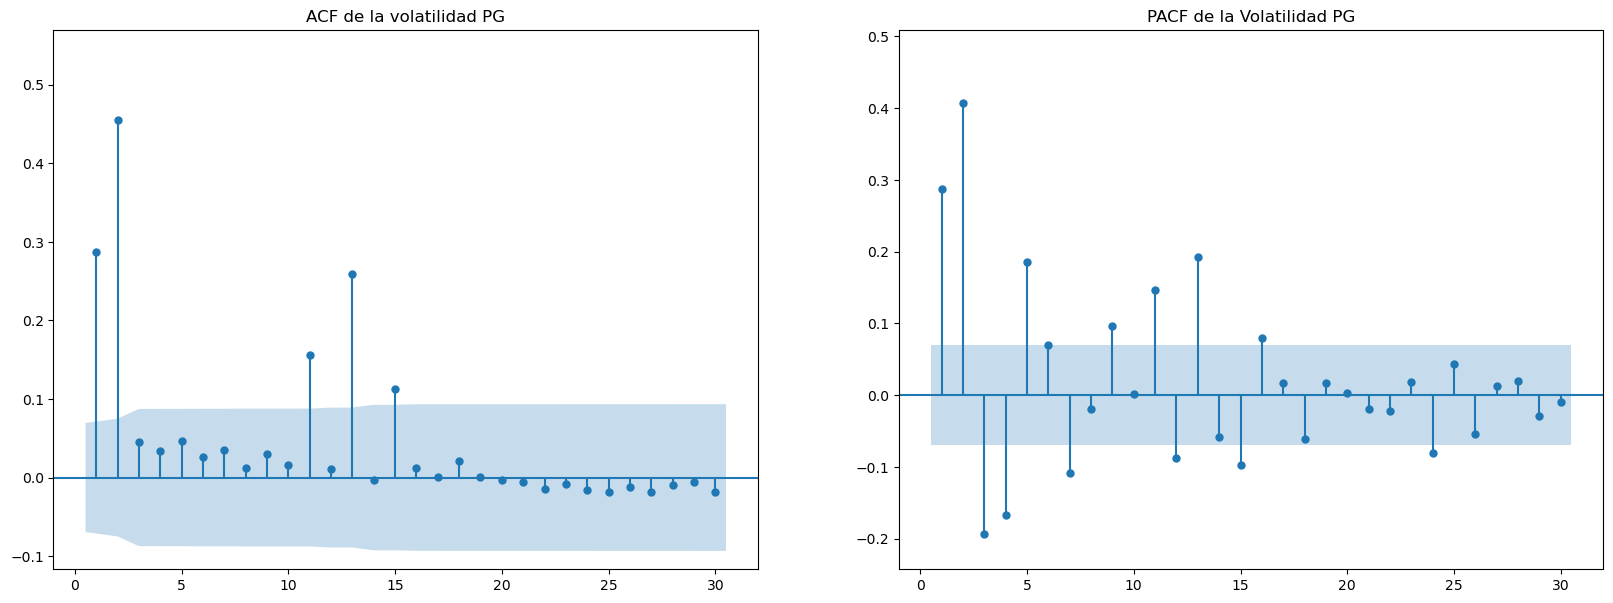

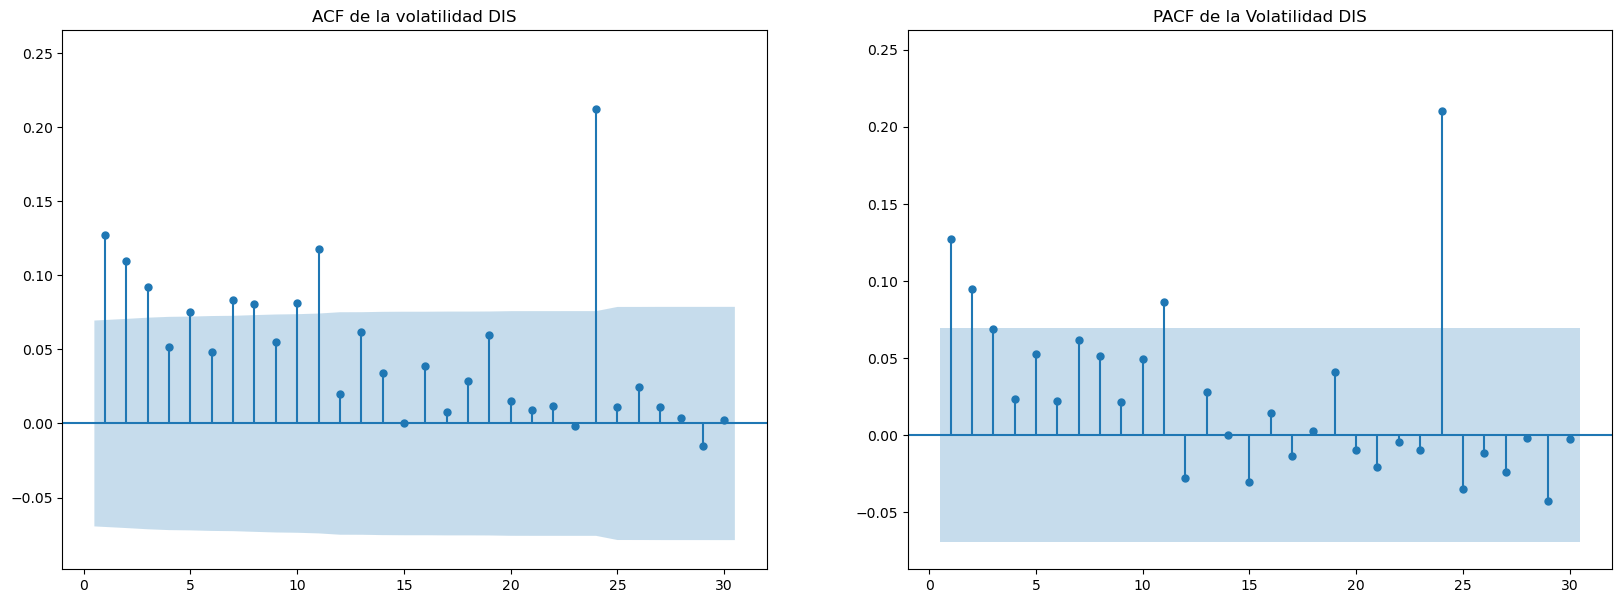

In [ ]:
for i in tickers[:2]:
    plt.rcParams["figure.figsize"] = (20, 7)

    fig, ax = plt.subplots(1,2)

    sgt.plot_acf(df['vol'+i].dropna(),ax=ax[0],zero = False, auto_ylims=True, title="ACF de la volatilidad "+i)
    sgt.plot_pacf(df['vol'+i].dropna(),ax=ax[1], zero = False,auto_ylims=True,title="PACF de la Volatilidad "+i);

In [105]:
# PG

In [ ]:
model1_GARCH52 = arch_model(df['residuo_PG'].dropna(), vol="GARCH", p=5, q=2, mean="AR")
results1_GARCH52 = model1_GARCH52.fit()
print(results1_GARCH52.summary())

Iteration:      1,   Func. Count:     11,   Neg. LLF: 2398.1686321902594
Iteration:      2,   Func. Count:     26,   Neg. LLF: 2730.3246983399767
Iteration:      3,   Func. Count:     38,   Neg. LLF: 2559.3791261635915
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2427.042939570628
Iteration:      5,   Func. Count:     61,   Neg. LLF: 2013.0810974872154
Iteration:      6,   Func. Count:     72,   Neg. LLF: 1424.8722644063607
Iteration:      7,   Func. Count:     83,   Neg. LLF: 1427.01302023454
Iteration:      8,   Func. Count:     94,   Neg. LLF: 1378.2564750226525
Iteration:      9,   Func. Count:    104,   Neg. LLF: 1377.2397882314733
Iteration:     10,   Func. Count:    114,   Neg. LLF: 1376.5193318925799
Iteration:     11,   Func. Count:    124,   Neg. LLF: 1376.160246845202
Iteration:     12,   Func. Count:    134,   Neg. LLF: 1376.123893309695
Iteration:     13,   Func. Count:    144,   Neg. LLF: 1376.1222314116371
Iteration:     14,   Func. Count:    154,   Neg. LLF: 13

In [ ]:
model1_GARCH11 = arch_model(df['residuo_PG'].dropna(), vol="GARCH", p=1, q=1, mean="AR")
results1_GARCH11 = model1_GARCH11.fit()
print(results1_GARCH11.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4590.327930514217
Iteration:      2,   Func. Count:     17,   Neg. LLF: 369417.32084235974
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1448.1869097866133
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1391.8517766356504
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1391.843347388852
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1391.8441372674288
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1391.8425337496783
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1391.8425318981094
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1391.8425295931484
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1391.8425318981094
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
                           AR - GARCH Model Results                           
Dep. Variable:             residuo_PG   R-squared:        

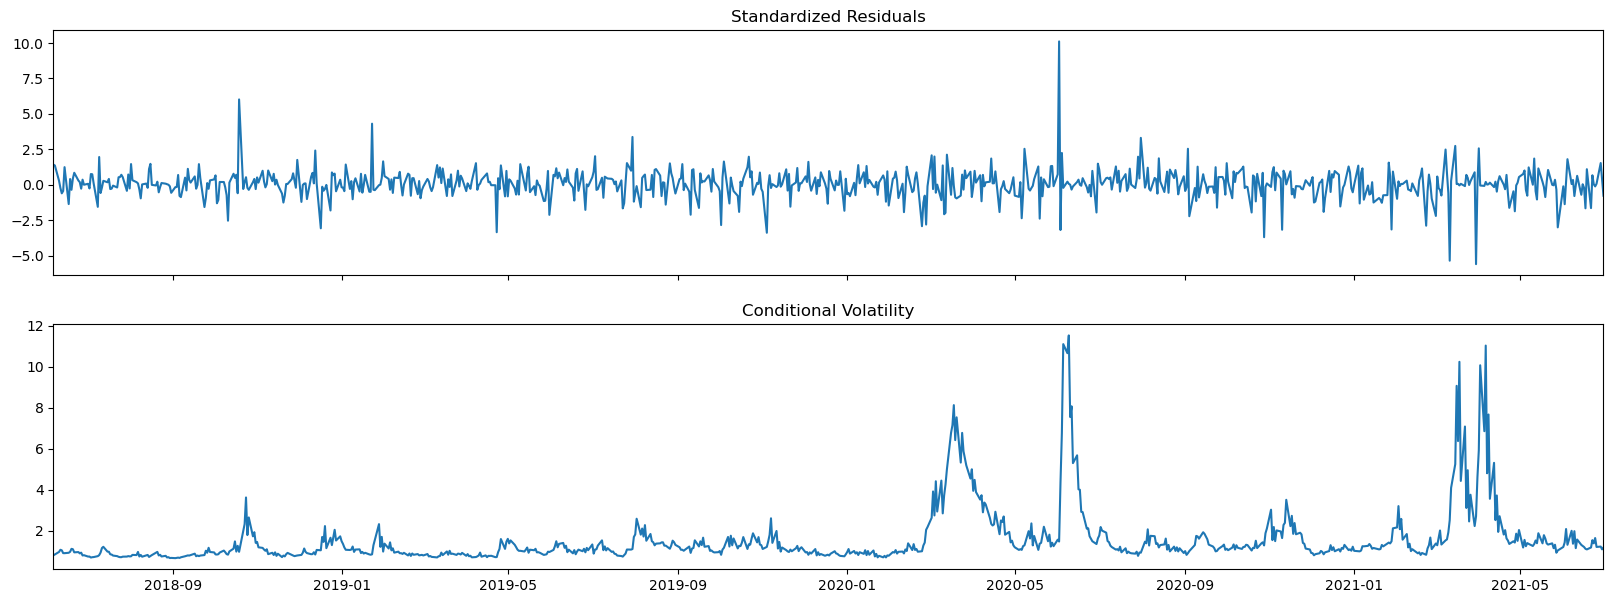

In [108]:
results1_GARCH52.plot()
plt.show()

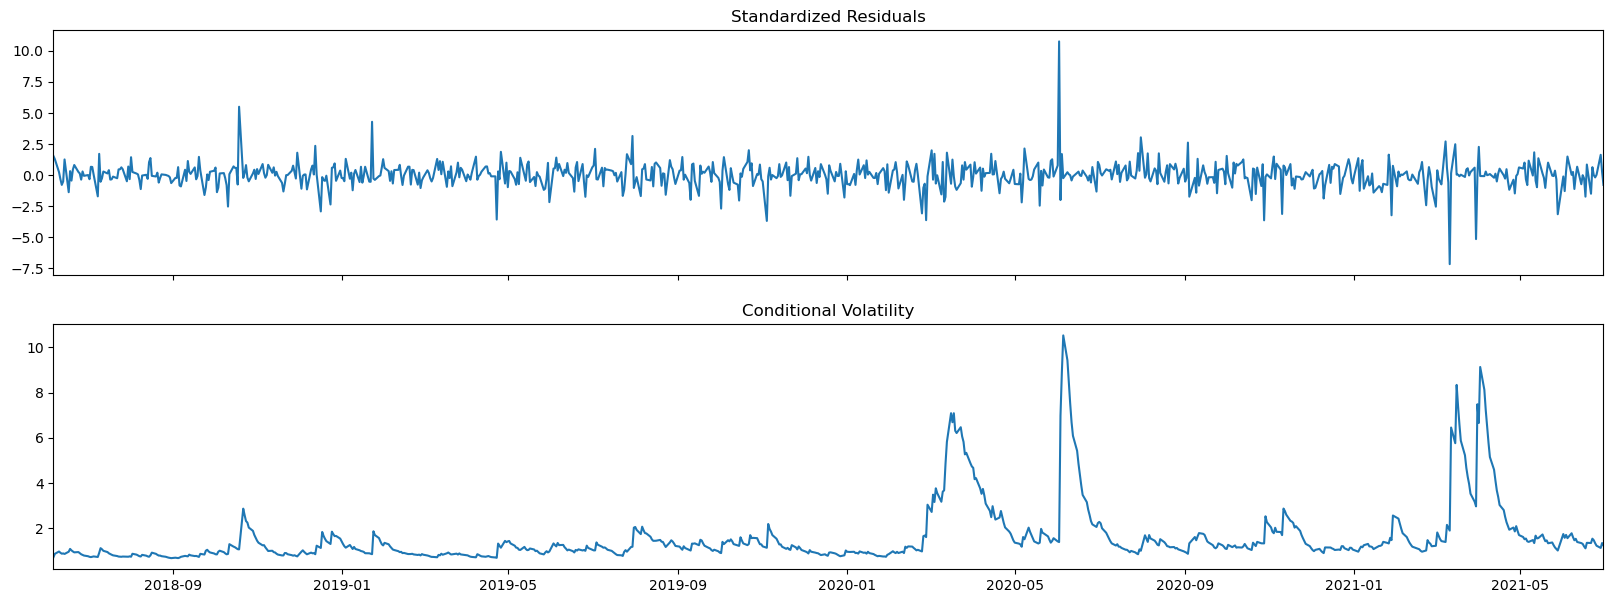

In [109]:
results1_GARCH11.plot()
plt.show()

In [110]:
GARCH52_resid = results1_GARCH52.std_resid
lm_test = het_arch(GARCH52_resid.dropna())
print(f"P-valor ARCH: {lm_test[3]:.4f}")

P-valor ARCH: 0.9308


In [111]:
GARCH11_resid = results1_GARCH11.std_resid
lm_test = het_arch(GARCH11_resid.dropna())
print(f"P-valor ARCH: {lm_test[3]:.4f}")

P-valor ARCH: 0.9993


In [112]:
index = df.index
index=index[len(index):None:-1] 
start_loc = 0
max_obs = len(model1_GARCH52.y) 
end_loc = max_obs - 20  

forecasts = {}
for i in range(20):
    last_obs_index = i + end_loc
    res = model1_GARCH52.fit(first_obs=start_loc, last_obs=last_obs_index, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_expand_GARCH52 = pd.DataFrame(forecasts).T
pred_variance_expand_GARCH52

,h.1
2021-06-02,4.435445
2021-06-03,1.726894
2021-06-04,4.024816
2021-06-07,1.916572
2021-06-08,3.947685
2021-06-09,1.353699
2021-06-10,2.495722
2021-06-11,1.743320
2021-06-14,1.601480
2021-06-15,1.475110


In [113]:
forecasts = {}
for i in range(20):
    res = model1_GARCH52.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
pred_variance_fixed_GARCH52 = pd.DataFrame(forecasts).T
pred_variance_fixed_GARCH52

 Done!


,h.1
2021-06-02,4.435445
2021-06-03,1.723772
2021-06-04,4.007296
2021-06-07,1.924393
2021-06-08,3.957525
2021-06-09,1.353631
2021-06-10,2.497138
2021-06-11,1.739964
2021-06-14,1.608155
2021-06-15,1.475951


In [114]:
index = df.index
index=index[len(index):None:-1] 
start_loc = 0
max_obs = len(model1_GARCH11.y) 
end_loc = max_obs - 20  

forecasts = {}
for i in range(20):
    last_obs_index = i + end_loc
    res = model1_GARCH11.fit(first_obs=start_loc, last_obs=last_obs_index, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_expand_GARCH11 = pd.DataFrame(forecasts).T
pred_variance_expand_GARCH11

,h.1
2021-06-02,2.924116
2021-06-03,2.447317
2021-06-04,3.176299
2021-06-07,2.587957
2021-06-08,2.162281
2021-06-09,2.353371
2021-06-10,1.942266
2021-06-11,1.806785
2021-06-14,1.712428
2021-06-15,1.433368


In [115]:
forecasts = {}
for i in range(20):
    res = model1_GARCH11.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
pred_variance_fixed_GARCH11 = pd.DataFrame(forecasts).T
pred_variance_fixed_GARCH11

 Done!


,h.1
2021-06-02,2.924116
2021-06-03,2.444931
2021-06-04,3.179545
2021-06-07,2.592199
2021-06-08,2.166492
2021-06-09,2.355616
2021-06-10,1.944153
2021-06-11,1.811120
2021-06-14,1.718319
2021-06-15,1.441555


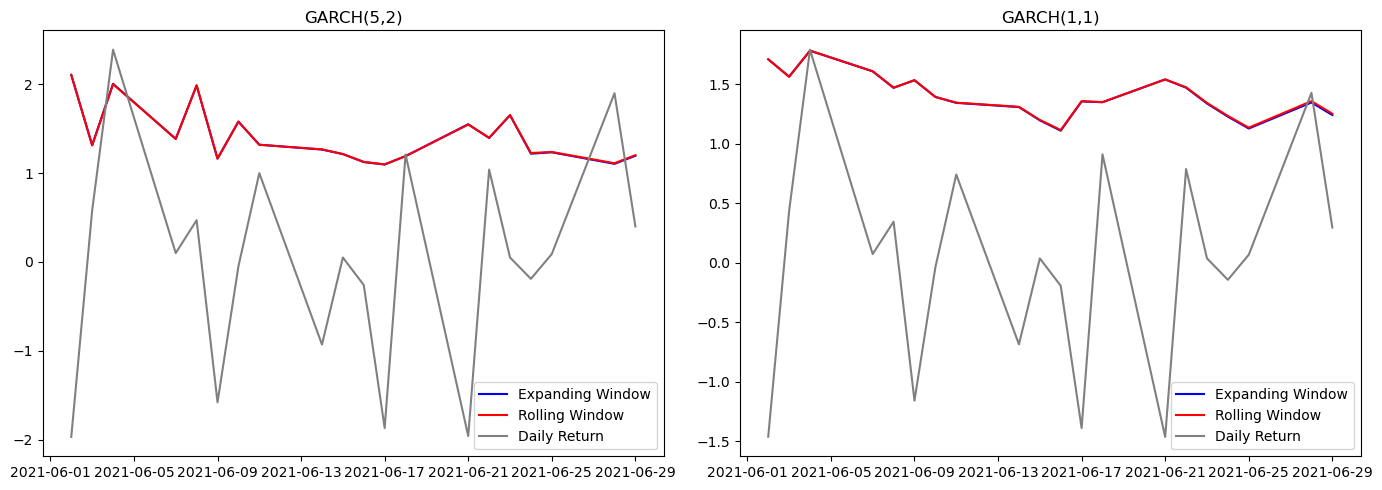

In [ ]:
# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- GARCH(5,2) ---
pred_vol_expand_GARCH52 = np.sqrt(pred_variance_expand_GARCH52)
pred_vol_fixedwin_GARCH52 = np.sqrt(pred_variance_fixed_GARCH52)

axes[0].plot(pred_vol_expand_GARCH52, color='blue', label='Expanding Window')
axes[0].plot(pred_vol_fixedwin_GARCH52, color='red', label='Rolling Window')
axes[0].plot(df['residuo_PG'].loc[pred_variance_expand_GARCH52.index],
             color='grey', label='Daily Return')
axes[0].set_title('GARCH(5,2)')
axes[0].legend()

# --- GARCH(1,1) ---
pred_vol_expand_GARCH11 = np.sqrt(pred_variance_expand_GARCH11)
pred_vol_fixedwin_GARCH11 = np.sqrt(pred_variance_fixed_GARCH11)

axes[1].plot(pred_vol_expand_GARCH11, color='blue', label='Expanding Window')
axes[1].plot(pred_vol_fixedwin_GARCH11, color='red', label='Rolling Window')
axes[1].plot(df['renta_PG'].loc[pred_variance_expand_GARCH11.index],
             color='grey', label='Daily Return')
axes[1].set_title('GARCH(1,1)')
axes[1].legend()

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [ ]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast);
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast);
    print('Mean Squared Error (MSE): {:.3g}'.format(mse))
    return mae, mse

In [118]:
vol = df['residuo_PG'].sub(df['residuo_PG'].mean()).pow(2)[pred_variance_expand_GARCH52.index]
var = df['residuo_PG'].sub(df['residuo_PG'].mean())[pred_variance_expand_GARCH52.index]

In [119]:
evaluate(vol, pred_vol_expand_GARCH52);
evaluate(vol, pred_vol_fixedwin_GARCH52);

Mean Absolute Error (MAE): 1.46
Mean Squared Error (MSE): 2.8
Mean Absolute Error (MAE): 1.46
Mean Squared Error (MSE): 2.8


In [120]:
vol = df['residuo_PG'].sub(df['residuo_PG'].mean()).pow(2)[pred_variance_expand_GARCH11.index]
var = df['residuo_PG'].sub(df['residuo_PG'].mean())[pred_variance_expand_GARCH11.index]

In [121]:
evaluate(vol, pred_vol_expand_GARCH11);
evaluate(vol, pred_vol_fixedwin_GARCH11);

Mean Absolute Error (MAE): 1.42
Mean Squared Error (MSE): 2.7
Mean Absolute Error (MAE): 1.42
Mean Squared Error (MSE): 2.71


In [122]:
# DIS

In [123]:
model2_GARCH23 = arch_model(df['residuo_DIS'].dropna(), vol="GARCH", p=2, q=3, mean="AR")
results2_GARCH23 = model2_GARCH23.fit()
print(results2_GARCH23.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4625.231011131431
Iteration:      2,   Func. Count:     23,   Neg. LLF: 2734.6468719217382
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1815.4655128842608
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1794.4183764718541
Iteration:      5,   Func. Count:     52,   Neg. LLF: 1810.9208990889224
Iteration:      6,   Func. Count:     61,   Neg. LLF: 1799.1662858806067
Iteration:      7,   Func. Count:     70,   Neg. LLF: 1823.3546709655386
Iteration:      8,   Func. Count:     80,   Neg. LLF: 1793.1048973571988
Iteration:      9,   Func. Count:     89,   Neg. LLF: 1792.585902471901
Iteration:     10,   Func. Count:     97,   Neg. LLF: 6354.868770497022
Iteration:     11,   Func. Count:    107,   Neg. LLF: 1792.5119438819174
Iteration:     12,   Func. Count:    115,   Neg. LLF: 1792.5045694984203
Iteration:     13,   Func. Count:    123,   Neg. LLF: 1792.5030211599042
Iteration:     14,   Func. Count:    131,   Neg. LLF: 

In [124]:
model2_GARCH11 = arch_model(df['residuo_DIS'].dropna(), vol="GARCH", p=1, q=1, mean="AR")
results2_GARCH11 = model2_GARCH11.fit()
print(results2_GARCH11.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3893.205527466236
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3257.3764120278174
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1827.1778595393562
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3067.8244080745835
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1793.6233088459803
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1905.2381168929815
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1796.3801861443417
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1792.6479277558165
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1792.6045692347936
Iteration:     10,   Func. Count:     63,   Neg. LLF: 1792.60440382052
Iteration:     11,   Func. Count:     67,   Neg. LLF: 1792.604403819083
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1792.60440382052
            Iterations: 11
            Function evaluations: 67
            Gradient evaluatio

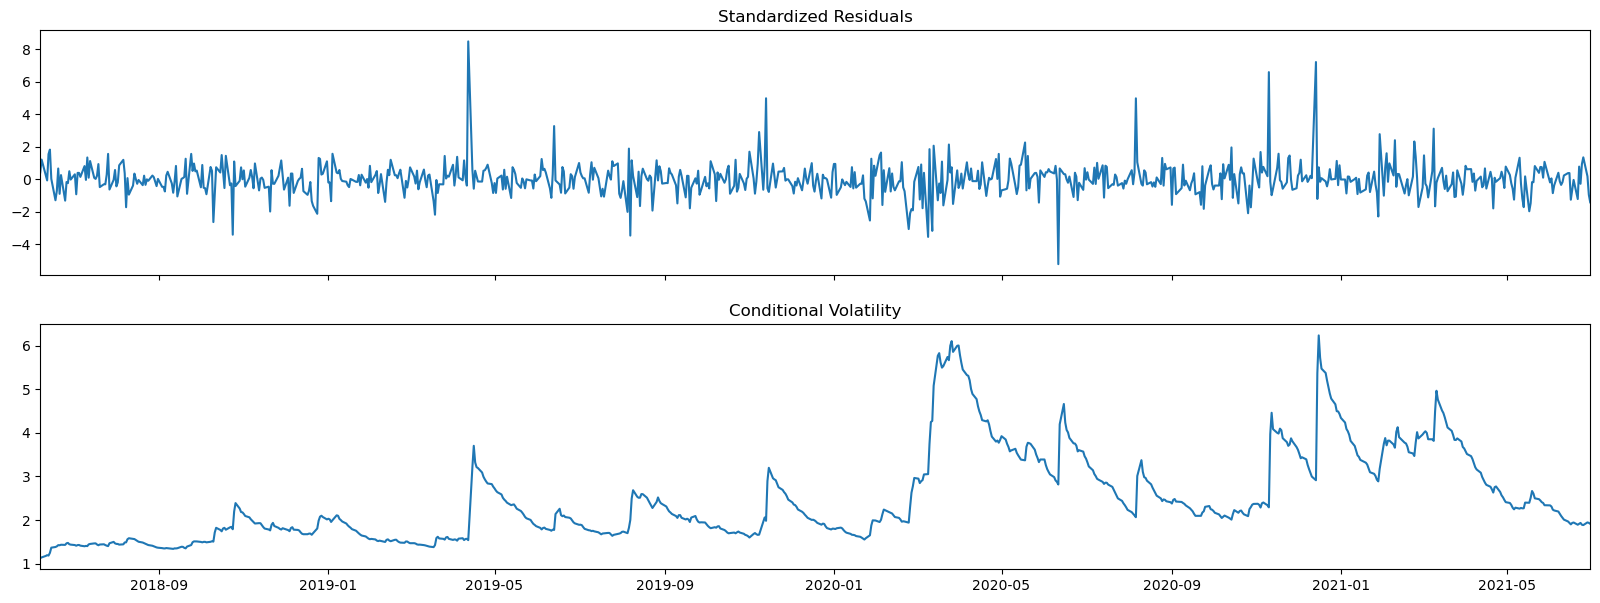

In [125]:
results2_GARCH23.plot()
plt.show()

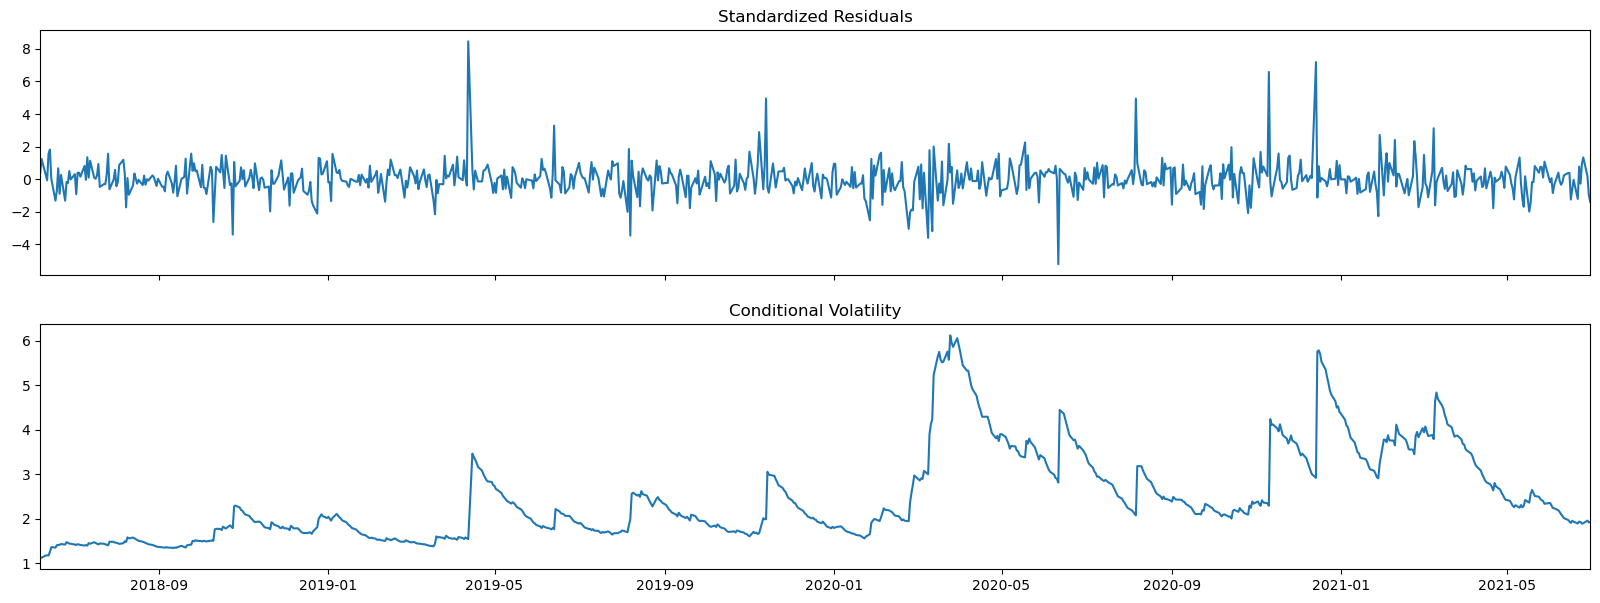

In [126]:
results2_GARCH11.plot()
plt.show()

In [127]:
GARCH23_resid = results2_GARCH23.std_resid
lm_test = het_arch(GARCH23_resid.dropna())
print(f"P-valor ARCH: {lm_test[3]:.4f}")

P-valor ARCH: 1.0000


In [128]:
GARCH11_resid = results2_GARCH11.std_resid
lm_test = het_arch(GARCH11_resid.dropna())
print(f"P-valor ARCH: {lm_test[3]:.4f}")

P-valor ARCH: 1.0000


In [129]:
index = df.index
index=index[len(index):None:-1] 
start_loc = 0
max_obs = len(model2_GARCH23.y) 
end_loc = max_obs - 20  

forecasts = {}
for i in range(20):
    last_obs_index = i + end_loc
    res = model2_GARCH23.fit(first_obs=start_loc, last_obs=last_obs_index, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_expand_GARCH23 = pd.DataFrame(forecasts).T
pred_variance_expand_GARCH23

,h.1
2021-06-02,5.187955
2021-06-03,5.176425
2021-06-04,4.961523
2021-06-07,4.760437
2021-06-08,4.539018
2021-06-09,4.359427
2021-06-10,4.161780
2021-06-11,3.934249
2021-06-14,3.832199
2021-06-15,3.637071


In [130]:
forecasts = {}
for i in range(20):
    res = model2_GARCH23.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_fixed_GARCH23 = pd.DataFrame(forecasts).T
pred_variance_fixed_GARCH23

,h.1
2021-06-02,5.187955
2021-06-03,5.164708
2021-06-04,4.952085
2021-06-07,4.740829
2021-06-08,4.508651
2021-06-09,4.290596
2021-06-10,4.135080
2021-06-11,3.994895
2021-06-14,3.896829
2021-06-15,3.771658


In [131]:
index = df.index
index=index[len(index):None:-1] 
start_loc = 0
max_obs = len(model2_GARCH11.y) 
end_loc = max_obs - 20  

forecasts = {}
for i in range(20):
    last_obs_index = i + end_loc
    res = model2_GARCH11.fit(first_obs=start_loc, last_obs=last_obs_index, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_expand_GARCH11 = pd.DataFrame(forecasts).T
pred_variance_expand_GARCH11

,h.1
2021-06-02,5.179184
2021-06-03,5.135694
2021-06-04,4.927737
2021-06-07,4.736335
2021-06-08,4.514035
2021-06-09,4.329336
2021-06-10,4.130453
2021-06-11,3.947882
2021-06-14,3.796363
2021-06-15,3.652284


In [132]:
forecasts = {}
for i in range(20):
    res = model2_GARCH11.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_fixed_GARCH11 = pd.DataFrame(forecasts).T
pred_variance_fixed_GARCH11

,h.1
2021-06-02,5.179184
2021-06-03,5.125802
2021-06-04,4.919569
2021-06-07,4.718962
2021-06-08,4.486843
2021-06-09,4.322680
2021-06-10,4.148791
2021-06-11,3.961174
2021-06-14,3.856007
2021-06-15,3.728877


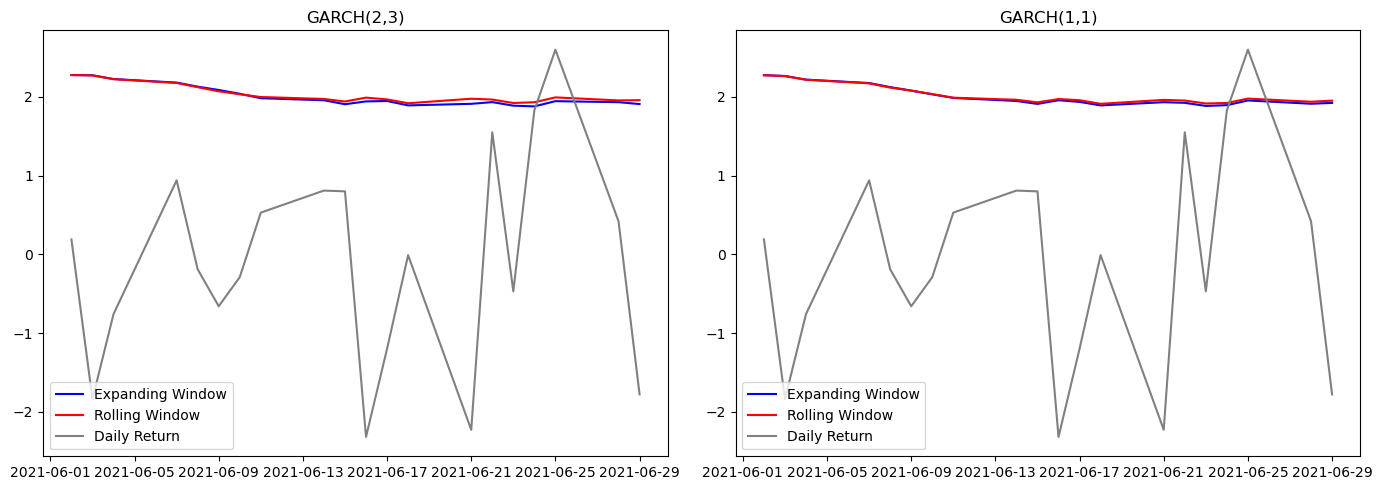

In [ ]:
# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- GARCH(2,3) ---
pred_vol_expand_GARCH23 = np.sqrt(pred_variance_expand_GARCH23)
pred_vol_fixedwin_GARCH23 = np.sqrt(pred_variance_fixed_GARCH23)

axes[0].plot(pred_vol_expand_GARCH23, color='blue', label='Expanding Window')
axes[0].plot(pred_vol_fixedwin_GARCH23, color='red', label='Rolling Window')
axes[0].plot(df['residuo_DIS'].loc[pred_variance_expand_GARCH23.index],
             color='grey', label='Daily Return')
axes[0].set_title('GARCH(2,3)')
axes[0].legend()

# --- GARCH(3,1,1) ---
pred_vol_expand_GARCH11 = np.sqrt(pred_variance_expand_GARCH11)
pred_vol_fixedwin_GARCH11 = np.sqrt(pred_variance_fixed_GARCH11)

axes[1].plot(pred_vol_expand_GARCH11, color='blue', label='Expanding Window')
axes[1].plot(pred_vol_fixedwin_GARCH11, color='red', label='Rolling Window')
axes[1].plot(df['residuo_DIS'].loc[pred_variance_expand_GARCH11.index],
             color='grey', label='Daily Return')
axes[1].set_title('GARCH(1,1)')
axes[1].legend()

# Ajustar diseño
plt.tight_layout()
plt.show()


In [134]:
vol = df['residuo_DIS'].sub(df['residuo_DIS'].mean()).pow(2)[pred_variance_expand_GARCH23.index]
var = df['residuo_DIS'].sub(df['residuo_DIS'].mean())[pred_variance_expand_GARCH23.index]

In [135]:
evaluate(vol, pred_vol_expand_GARCH23);
evaluate(vol, pred_vol_fixedwin_GARCH23);

Mean Absolute Error (MAE): 1.85
Mean Squared Error (MSE): 4.43
Mean Absolute Error (MAE): 1.84
Mean Squared Error (MSE): 4.37


In [136]:
vol = df['residuo_DIS'].sub(df['residuo_DIS'].mean()).pow(2)[pred_variance_expand_GARCH11.index]
var = df['residuo_DIS'].sub(df['residuo_DIS'].mean())[pred_variance_expand_GARCH11.index]

In [137]:
evaluate(vol, pred_vol_expand_GARCH11);
evaluate(vol, pred_vol_fixedwin_GARCH11);

Mean Absolute Error (MAE): 1.84
Mean Squared Error (MSE): 4.39
Mean Absolute Error (MAE): 1.84
Mean Squared Error (MSE): 4.38
